Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [185]:
from collections import namedtuple
from random import choice
from tqdm.auto import tqdm
import numpy as np
from heapq import heappush, heappop
import functools
import matplotlib.pyplot as plt
from time import time
import json

In [186]:
np.random.seed(42)

In [ ]:
PUZZLE_DIM = 4
RANDOMIZE_STEPS = 10_000
STEP_SIZE = 1000
TEMPERATURE = 10
MIN_PUZZLE_DIM = 2
MAX_PUZZLE_DIM = 7
TRIALS_BASE = 10
OUTFILE = "out.json"

action = namedtuple('Action', ['pos1', 'pos2'])

### State
Class to make a numpy array hashable

In [188]:
class State:
    def __init__(self, content: np.ndarray):
        self.content: np.ndarray = content
        self.hash: int = hash(content.tobytes())
        
    def __hash__(self):
        return self.hash

    def __eq__(self, other):
        return self.hash == other.hash
    
    def __lt__(self, other):
        return self.hash < other.hash

### Actions

In [ ]:
def available_actions(state: np.ndarray) -> list['Action']:
    puzzle_dim = state.shape[0]
    x, y = [int(i[0]) for i in np.where(state == 0)]
    actions = list()
    if x > 0:
        actions.append(action((x, y), (x - 1, y)))
    if x < puzzle_dim - 1:
        actions.append(action((x, y), (x + 1, y)))
    if y > 0:
        actions.append(action((x, y), (x, y - 1)))
    if y < puzzle_dim - 1:
        actions.append(action((x, y), (x, y + 1)))
    return actions

def counter(fn):

    @functools.wraps(fn)
    def helper(*args, **kargs):
        helper.calls += 1
        return fn(*args, **kargs)

    helper.calls = 0
    return helper

@counter
def do_action(state: np.ndarray, action: 'Action') -> np.ndarray:
    new_state = state.copy()
    new_state[action.pos1], new_state[action.pos2] = new_state[action.pos2], new_state[action.pos1]
    return new_state

## A* algorithm 

### Distance computation
Sum of Manhattan distances, eventually exponentiated

In [ ]:
def get_pos(state_content: np.ndarray, n: int) -> tuple[int, int]:
    x, y = np.argwhere(state_content== n)[0]
    return x, y

def manhattan_distance(state: np.ndarray, goal: np.ndarray, n: int, p: float = 1) -> int:
	x1, y1 = get_pos(state, n)
	x2, y2 = get_pos(goal, n)
	return (abs(x1 - x2) + abs(y1 - y2)) ** p

### Heuristics
Only *fixed_heuristic* is used in the final solution, as observed in the [experiments](#experiments)

In [ ]:
def fixed_heuristic(state: np.ndarray, goal: np.ndarray, step: int = None, exp: float = None, p: float = 1) -> int:
    puzzle_dim = state.shape[0]
    return sum([manhattan_distance(state, goal, n, p=p) for n in range(1, puzzle_dim**2)]) ** exp

def step_scheduling_heuristic(state: np.ndarray, goal: np.ndarray, step: int = TEMPERATURE * STEP_SIZE, exp: float = None) -> int:
    puzzle_dim = state.shape[0]
    return sum([manhattan_distance(state, goal, n) for n in range(1, puzzle_dim**2)]) ** (min(1 + (step // STEP_SIZE) / TEMPERATURE, 2))

def arctan_scheduling_heuristic(state: np.ndarray, goal: np.ndarray, step: int = TEMPERATURE * STEP_SIZE, exp: float = None) -> int:
	puzzle_dim = state.shape[0]
	return sum([manhattan_distance(state, goal, n) for n in range(1, puzzle_dim**2)]) ** (np.arctan(step / STEP_SIZE) + 1)

### Metrics
Quality is the inverse of path length.

Cost is the number an action is performed

In [ ]:
def quality(solution: list[int]) -> int:
    assert solution
    return 1 / len(solution)

def cost() -> int:
    return do_action.calls

### Algorithm

In [ ]:
def astar(state: np.ndarray, goal: np.ndarray, heuristic, exp = 1) -> tuple[bool, list['Action']]:
    
	path_len = lambda x: len(x)		# directly defined here to avoid numerical issues if using quality definition

	state, goal = map(State, [state, goal])
	open_set = []
	closed_set = set()
	past_len = {state: 0}
 
	heappush(open_set, (0, state, []))
	closed_set.add(state)

	steps = 0
	while open_set:
		
		_, current, curr_path = heappop(open_set)

		# Only for logging
		if steps % 10000 == 0:
			print(f"steps: {steps}, open: {len(open_set)}, closed: {len(closed_set)}, dist: {fixed_heuristic(current.content, goal.content, exp=1, p=1)}, len: {len(curr_path)}")

		if current == goal:
			return True, curr_path

		for action in available_actions(current.content):
			neighbor = State(do_action(current.content, action))

			if neighbor not in closed_set or past_len[current] + 1 < past_len[neighbor]:
				past_len[neighbor] = path_len(curr_path) + 1
				cost = past_len[neighbor] + heuristic(neighbor.content, goal.content, step=steps, exp=exp)
				heappush(open_set, (cost, neighbor, curr_path + [action]))
				closed_set.add(neighbor)

		steps += 1
    
    # It should not arrive here!
	return False, []

### Initialization functions

In [192]:
def init_state(goal: np.ndarray, puzzle_dim: int = PUZZLE_DIM, randomize_steps=RANDOMIZE_STEPS) -> np.ndarray:
    state = goal.copy()
    np.random.shuffle(state.flatten())
    for _ in range(randomize_steps):
        state = do_action(state, choice(available_actions(state)))
    return state.reshape(puzzle_dim, puzzle_dim)

def set_goal(puzzle_dim: int) -> np.ndarray:
    goal = np.array([n for n in range(1, puzzle_dim**2)] + [0])
    return goal.reshape((puzzle_dim, puzzle_dim)) 

### Statistics computation
Quality, cost and elapsed time are computed. Useful in particular for experiments

In [193]:
def statistics(results_values):
    quality_sol, cost_sol, elapsed = tuple(zip(*(results_values)))
    avg_quality, avg_cost, avg_elapsed = map(lambda x: np.mean(np.array(x)), [quality_sol, cost_sol, elapsed])
    return avg_quality, avg_cost, avg_elapsed

### Solve functions
Used to call the solver algorithm on different instances and trials

In [ ]:
def solve_instance(puzzle_dim: int, heuristic, exp=None) -> np.ndarray:
    goal = set_goal(puzzle_dim)
    content = init_state(goal, puzzle_dim, randomize_steps=1400)
    do_action.calls = 0
    
    converged, path = astar(content, goal, heuristic, exp=exp)
    
    assert converged

    return quality(path), do_action.calls


def solve_size(puzzle_dim: int, heuristic, tries: int = TRIALS_BASE, exp=None):
    
    qualities, costs = [], []
    for t in range(tries):
        print(f"Instance {t}")
        sol_quality, sol_cost = solve_instance(puzzle_dim, heuristic, exp=exp)
        qualities.append(sol_quality)
        costs.append(sol_cost)
    
    tot_quality, tot_cost = map(lambda x: np.array(x).mean(), [qualities, costs])
    
    return tot_quality, tot_cost, tot_quality / tot_cost


def solve(min_puz_dim, max_puz_dim, heuristics: dict, exp: dict = None, tries: dict = None):
    
    names = ["quality", "cost", "efficiency"]
    results = dict()
    for puzzle_dim in range(min_puz_dim, max_puz_dim+1):
        print(f"Solving for size {puzzle_dim}")
        sol_quality, sol_cost, sol_efficiency = solve_size(puzzle_dim, heuristics[puzzle_dim], tries[puzzle_dim], exp=exp[puzzle_dim])
        
        results[puzzle_dim] = dict(zip(names, [sol_quality, sol_cost, sol_efficiency]))
        
    return results

### Heuristics data structure
Used as helper for the experiments

In [ ]:
strategies = ["fixed", "step scheduling", "arctan scheduling"]
functions = [fixed_heuristic, step_scheduling_heuristic, arctan_scheduling_heuristic]
heuristics = dict(zip(strategies, functions))

### Parameter setup
Used to set the values of the parameters for each problem size

In [ ]:
HEURISTICS_PER_SIZE = {
    2: fixed_heuristic,
    3: fixed_heuristic,
    4: fixed_heuristic,
    5: fixed_heuristic,
    6: fixed_heuristic,
    7: fixed_heuristic,
    8: fixed_heuristic,
    9: fixed_heuristic
}
EXP_PER_SIZE = {
    puzzle_dim: 1 if puzzle_dim <= 3 else (1.8 if puzzle_dim <= 7 else 4) for puzzle_dim in range(MIN_PUZZLE_DIM, MAX_PUZZLE_DIM+1)
}
TRIALS_PER_SIZE = {
    2: TRIALS_BASE,
    3: TRIALS_BASE,
    4: TRIALS_BASE,
    5: TRIALS_BASE // 2,
    6: TRIALS_BASE // 4,
    7: TRIALS_BASE // 8,
    8: TRIALS_BASE // 8,
    9: TRIALS_BASE // 8
}

{2: 1, 3: 1, 4: 1.8, 5: 1.8, 6: 1.8, 7: 1.8}

### Output functions
Used to print, save on file and plot results

In [ ]:
def print_results(results):
    for (puzzle_dim, result) in results.items():
        print(f"Puzzle dimension: {puzzle_dim}")
        avg_quality, avg_cost, avg_efficiency = map(result.get, list(result.keys()))
        print(f"Quality: {avg_quality:.5f}")
        print(f"Cost: {avg_cost:.3f}")
        print(f"Efficiency: {avg_efficiency:.3e}")
        print()

def save_results(results: dict, filename: str):
    file = open(filename, mode="w", encoding="utf-8")
    json.dump(results, file, indent=4)
    
def plot_results(results):
    puz_dimensions, qualities, costs, efficiencies = [], [], [], []
    for (puzzle_dim, result) in results.items():
        avg_quality, avg_cost, avg_efficiency = map(result.get, list(result.keys()))
        
        puz_dimensions.append(int(puzzle_dim))
        qualities.append(avg_quality)
        costs.append(avg_cost)
        efficiencies.append(avg_efficiency)
    
    plt.figure("efficiency")
    
    plt.semilogy(puz_dimensions, efficiencies, label="Efficiency", marker="o", mfc="red", mec="black")
    
    for (x, y) in zip(puz_dimensions, efficiencies):
        plt.text(x+0.02, 1.2*y, EXP_PER_SIZE[x])
    
    plt.suptitle("Efficiency", size=12)
    plt.title("Markers are annotated with exponent used", size=10)
    plt.xlabel("Puzzle dimension")
    plt.ylabel("Efficiency")
    plt.grid()
    
    
    plt.show()

### Execution of the solver

In [ ]:
results = solve(MIN_PUZZLE_DIM, MAX_PUZZLE_DIM, HEURISTICS_PER_SIZE, EXP_PER_SIZE, TRIALS_PER_SIZE)

### Post-processing and visualization

In [ ]:
save_results(results, OUTFILE)
print_results(results)
plot_results(results)

In [ ]:
fin = open("results.json", "r")
r = json.load(fin)
newr = dict()
for (size, rs) in r.items():
    newr[size] = {
        "quality": -1/rs["quality"],
        "cost": rs["cost"],
        "efficiency": -1/(rs["quality"]*rs["cost"])
    }
print(newr)
fout = open("results_new.json", "w")
json.dump(newr, fout, indent=4)

## Experiments

### Solvers
Ad-hoc solvers use as helper functions

In [ ]:
def solve(name, strategy, content, goal, exp=None):
	start = time()

	do_action.calls = 0
	success, path = astar(content, goal, strategy, exp=exp)
	elapsed = time() - start

	quality_sol, cost_sol = quality(path), do_action.calls
	print(f"{name}, {exp}: {success}, {quality_sol}, {cost_sol}, time: {elapsed:.2f} s")
	
	return ((name, exp), (quality_sol, cost_sol, elapsed))


def solve_instance(content, goal, results, heuristics=heuristics, exp_values=[2,3]):
	for (name, strategy) in heuristics.items():
		if name == "fixed":
			for exp in exp_values:
				algorithm, result = solve(name, strategy, content, goal, exp=exp)
				current = results.get(algorithm, [])
				current.append(result)
				results[algorithm] = current
		else:
			algorithm, result = solve(name, strategy, content, goal)
			current = results.get(algorithm, [])
			current.append(result)
			results[algorithm] = current

### Heuristic modification
Admissible heuristics are sometimes too slow at converging. The following part aims to find a non-admissible heuristic which can represent a good trade-off between optimality of the final solution and convergence time, which is related to the total cost of the problem (number of explored states).

In [ ]:
results = dict()	

TRIALS = 15
for i in range(TRIALS):
	goal = np.array([n for n in range(1, PUZZLE_DIM**2)] + [0]).reshape((PUZZLE_DIM, PUZZLE_DIM))
	content = init_state(goal)
	print(f"Instance {i}")
	print(content)
	solve_instance(content, goal, results)

for (algorithm, result) in results.items():
    avg_results = statistics(result)
    print(algorithm, avg_results)

# RAW RESULTS
# ('fixed', 2) (0.007514, 14753.52)
# ('fixed', 3) (0.006289, 15408.64)
# ('step scheduling', None) (0.009345, 53037.26)
# ('arctan scheduling', None) (0.007299, 26842.06)

### Test for randomizer step
This experiment focuses on understanding how could the number of initial randomize steps influence the final solution, in terms of quality and cost

In [ ]:
qualities, costs, elapseds = [], [], []

TRIALS = 15
values = list(map(int, np.logspace(1, 7, num=TRIALS).tolist()))
for (i, rand_steps) in enumerate(values):
	goal = np.array([n for n in range(1, PUZZLE_DIM**2)] + [0]).reshape((PUZZLE_DIM, PUZZLE_DIM))
	
	print(f"{i}: {rand_steps}")
 
	_TRIALS = 10
	_qualities, _costs, _elapseds = map(np.zeros, [_TRIALS] * 3)
	for _try in tqdm(range(_TRIALS)):
		content = init_state(goal, randomize_steps=rand_steps)
		_, (sol_quality, sol_cost, sol_elapsed) = solve("fixed", fixed_heuristic, content, goal, exp=2)
		_qualities[_try] = sol_quality
		_costs[_try] = sol_cost
		_elapseds[_try] = sol_elapsed
	
	sol_quality = _qualities.mean()
	sol_cost = _costs.mean()
	sol_elapsed = _elapseds.mean()
	
	qualities.append(sol_quality)
	costs.append(sol_cost)
	elapseds.append(sol_elapsed)

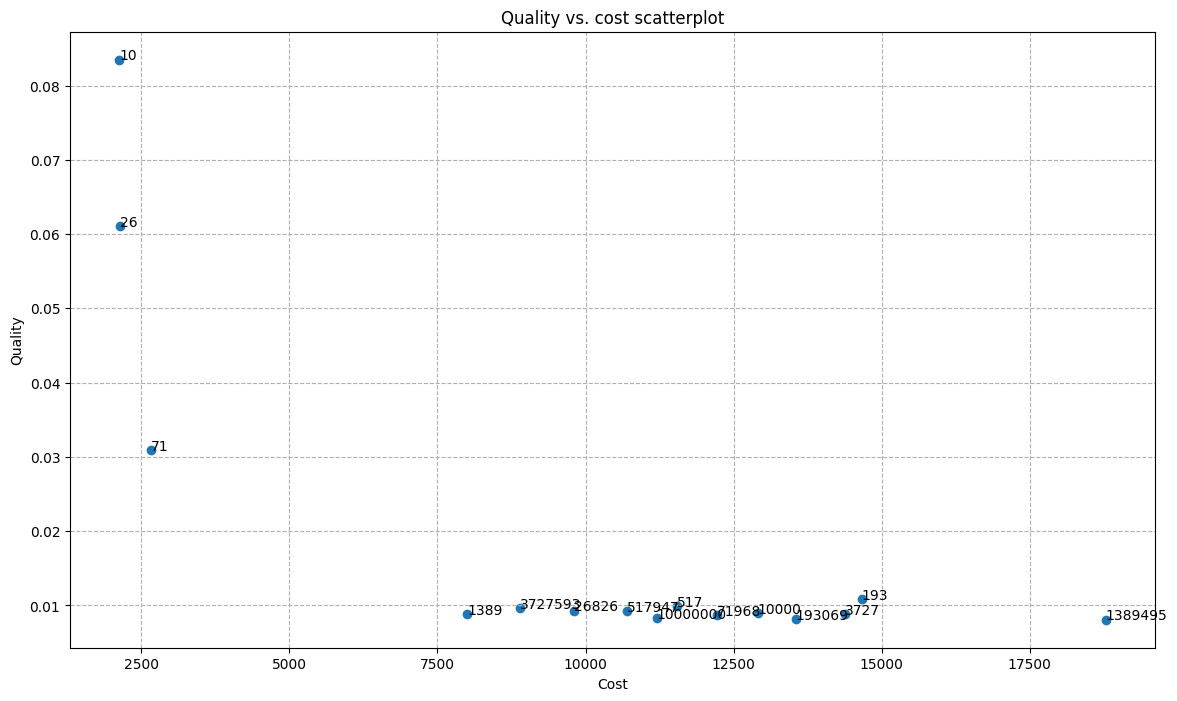

In [ ]:
plt.figure("scatter", figsize=(14,8))
plt.scatter(costs, qualities)
plt.title("Quality vs. cost scatterplot")
plt.xlabel("Cost")
plt.ylabel("Quality")
for (i, (c, q)) in enumerate(zip(costs, qualities)):
    plt.annotate(f"{int(values[i]):1d}", (c,q))
plt.grid(linestyle="--")

plt.show()

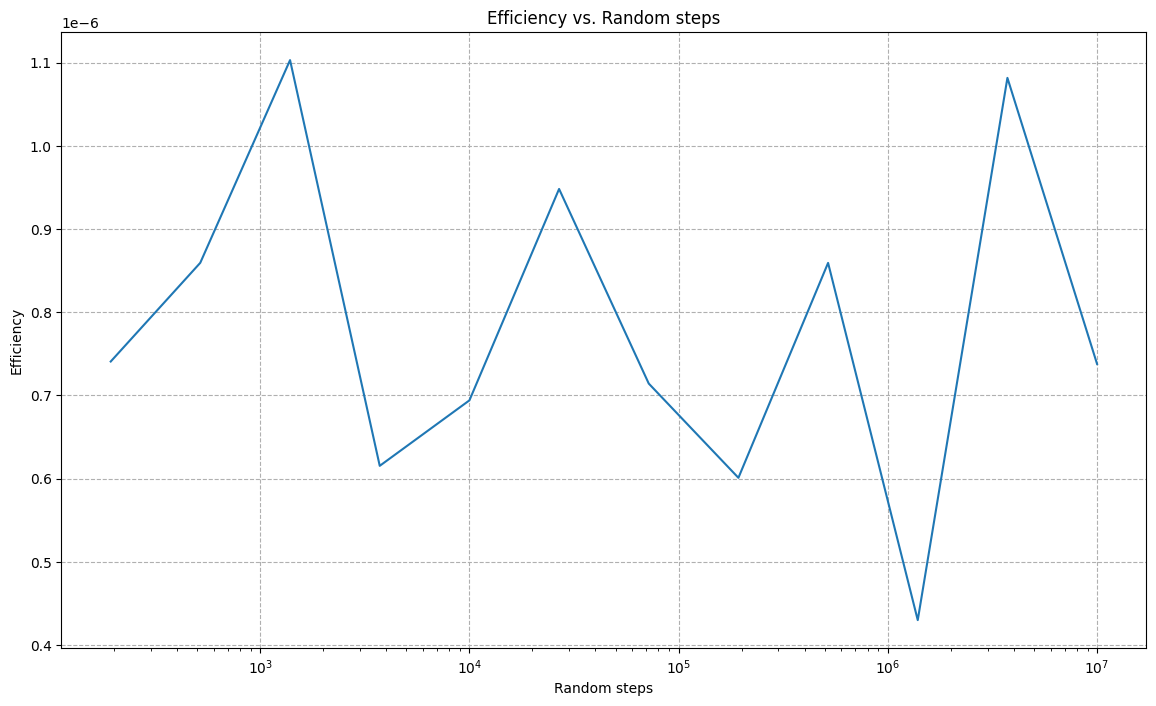

In [ ]:
eff = ((np.array(qualities[2:]) / np.array(costs[2:]))).tolist()
v = sorted([(s, e) for (s, e) in zip(values[2:]], eff)])
s = [x[0] for x in v]
e = [x[1] for x in v]
plt.figure("efficiency", figsize=(14,8))
plt.semilogx(s, e)
plt.title("Efficiency vs. Random steps")
plt.xlabel("Random steps")
plt.ylabel("Efficiency")
plt.grid(linestyle="--")
plt.show()

#### Results
For n > 200, the scatter points are always in the same region.
Hence, it is expected the algorithm behave in the same way across different instances, given n greater than some constant N.

To have some safety margin N >= 1000 is chosen.

### Fine-grained fixed exponent
Fixed exponent is chosen, since it balances quality vs cost better than others.
The value of the exponent is tweaked around 2, in a small range

In [ ]:
results = dict()

fixed_heur = dict(zip([strategies[0]], [functions[0]]))
exp_values = np.linspace(1.5, 2.2, num=8).tolist()[::-1]      # 0.1 step, starting from fastest

rand_steps_values = [1000, 1400]
for rand_steps in rand_steps_values:
    TRIALS = 10
    for i in range(TRIALS):
        goal = np.array([n for n in range(1, PUZZLE_DIM**2)] + [0]).reshape((PUZZLE_DIM, PUZZLE_DIM))
        content = init_state(goal, randomize_steps=rand_steps)
        print(f"Instance {i}")
        print(content)
        results[rand_steps] = dict()
        solve_instance(content, goal, results[rand_steps], heuristics=fixed_heur, exp_values=exp_values)

results

#### Post-processing

In [ ]:
avg_results = dict()
keys = ["quality", "cost", "elapsed"]

for (rand_steps, results_rand_steps) in results.items():
    avg_results[rand_steps] = dict()
    for ((_, exp), result) in results_rand_steps.items():
        avg_result = statistics(result)
        values = list(map(float, avg_result))
        avg_results[rand_steps][exp] = dict(zip(keys, values))

avg_results

In [ ]:
efficiencies = {rand_steps: [val["quality"]/val["cost"] for val in avg_results_steps.values()] for (rand_steps, avg_results_steps) in avg_results.items()}
efficiencies

In [ ]:
costs = {rand_steps: [val["cost"] for val in avg_results_steps.values()] for (rand_steps, avg_results_steps) in avg_results.items()}
costs

#### Visualization

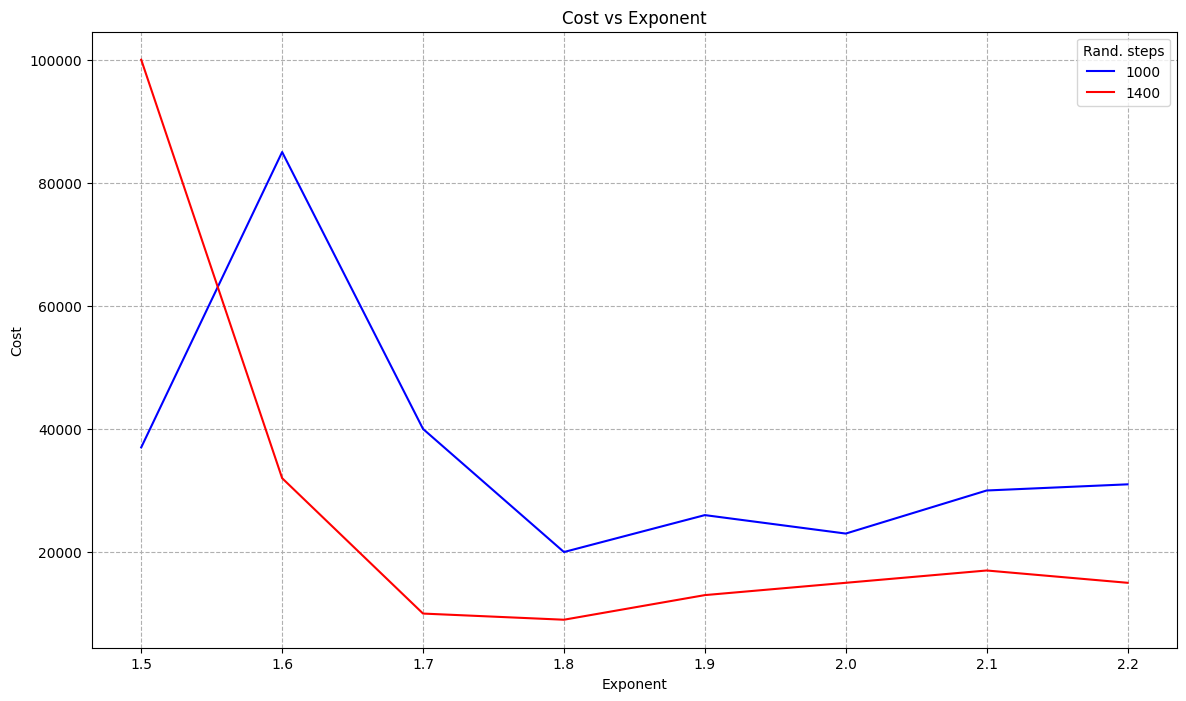

In [ ]:
plt.figure("cost vs. exp", figsize=(14,8))
colors = ["b", "r", "orange"]
for ((rand_steps, cost_steps), color) in zip(costs.items(), colors):
    plt.plot(exp_values, cost_steps, label=f"{rand_steps}", color=color)
plt.legend(title="Rand. steps")
plt.title("Cost vs Exponent")
plt.xlabel("Exponent")
plt.ylabel("Cost")
plt.grid(linestyle="--")

plt.show()

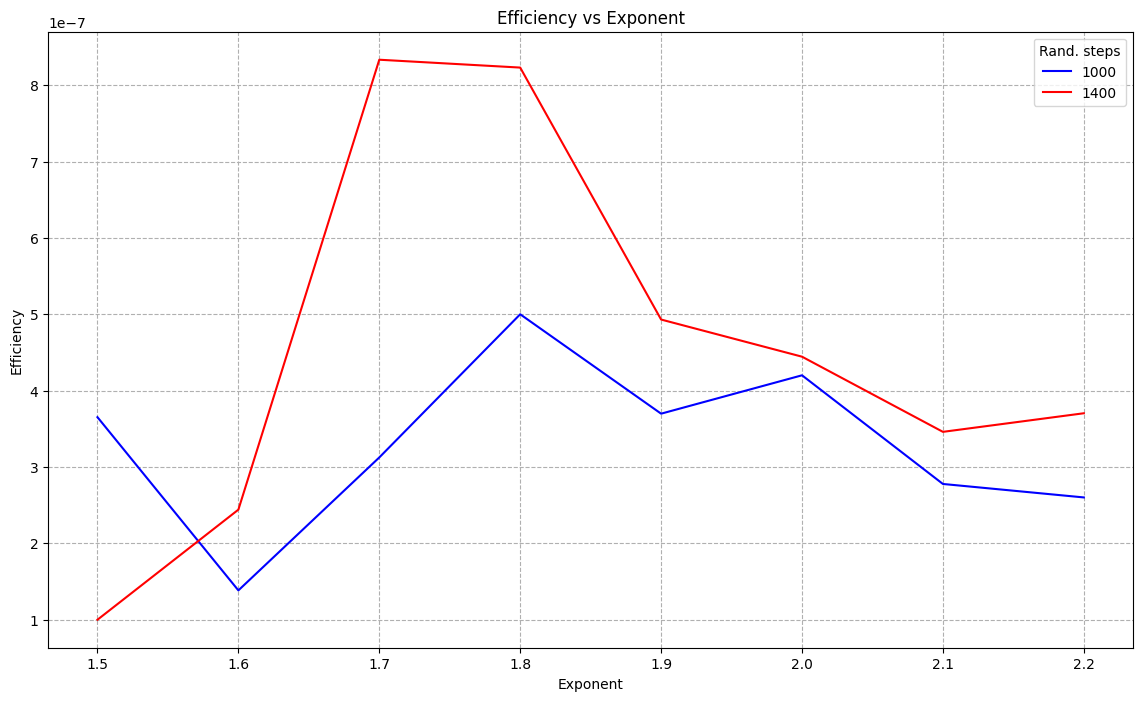

In [ ]:
plt.figure("eff vs. exp", figsize=(14,8))
colors = ["b", "r", "orange"]
for ((rand_steps, efficiencies_steps), color) in zip(efficiencies.items(), colors):
    plt.plot(exp_values, efficiencies_steps, label=f"{rand_steps}", color=color)
plt.legend(title="Rand. steps")
plt.title("Efficiency vs Exponent")
plt.xlabel("Exponent")
plt.ylabel("Efficiency")
plt.grid(linestyle="--")
plt.show()

#### Results
To avoid higher costs in larger problems, a low cost is preferred: by putting a threshold on 20'000 evaluations (which corresponds to about 4 seconds), the following setups are considered:
- rand steps = 1400, $exp \geq 1.7$
- rand_steps = 1000, $exp = 1.8$.

Efficiency is then considered:
- rand_steps = 1400, better on the whole interval, in particular in 1.8
- rand_steps = 1000 is worse on the whole interval, so it is discarded.

In conclusion:
- rand_steps = 1400, due to better general behavior
- exp = 1.8, due to lower cost in the region
  
could be a good solution. 